# Social Media Analytics Homework 1
#### *Siqi Chen (sc56839), Yuxin Li (yl24344), Gabriella Lio (gkl239), Jiahao Ye (jy7769), Boying You (by3475)*

## PART I


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, brier_score_loss, average_precision_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, label_binarize, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_csv('raw/train.csv')

In [3]:
train.shape

(5500, 23)

In [4]:
train.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


In [5]:
train.columns.values

array(['Choice', 'A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent',
       'B_posts', 'B_network_feature_1', 'B_network_feature_2',
       'B_network_feature_3'], dtype=object)

## a little EDA...

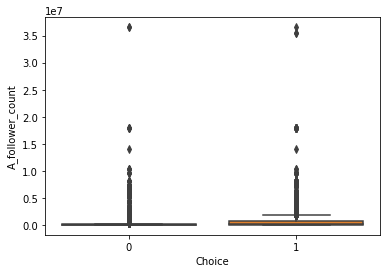

In [6]:
sns.boxplot(x = 'Choice', y ='A_follower_count',data=train)

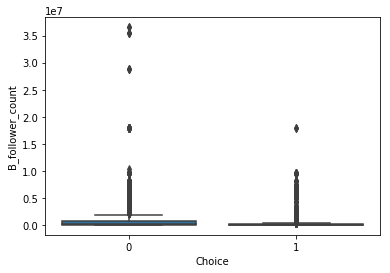

In [7]:
sns.boxplot(x = 'Choice', y ='B_follower_count',data=train)

### pairplots

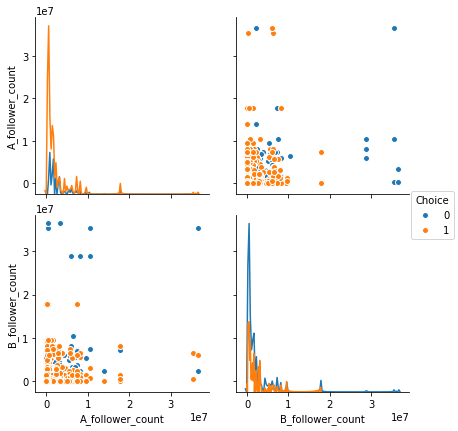

In [8]:
sns.pairplot(data=train, size = 3,hue='Choice', diag_kind='kde', vars=['A_follower_count','B_follower_count'])

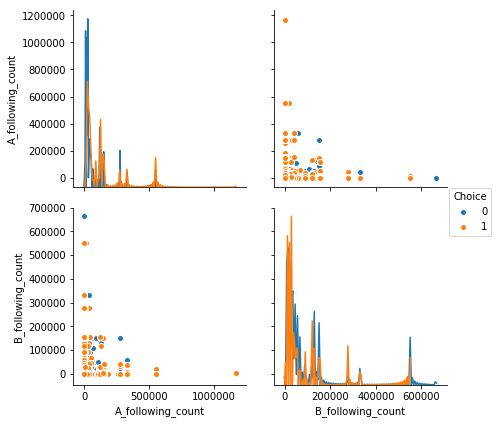

In [9]:
sns.pairplot(data=train, size = 3,hue='Choice', diag_kind='kde', vars=['A_following_count','B_following_count'])

#### Highly skewed, no very clear boundaries.

## Feature Transformation

In [10]:
features = [x[2:] for x in train.columns.values[1:12]]

In [11]:
#create new feature as ratio of A and B
for f in features:
    a = 'A_' + f
    b = 'B_' + f
    new = 'diff_' + f
    train[new] = 1.0*(train[a]+1)/(train[b]+1) #avoid zero division

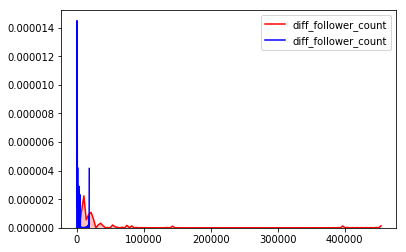

In [12]:
#check the density plot, very skewed, perform log transformation
sns.kdeplot(train[train.Choice == 1]['diff_follower_count'],color = 'red', shade = 'True')
sns.kdeplot(train[train.Choice == 0]['diff_follower_count'],color = 'blue', shade = 'True')

#### Still highly skewed, perform log transformation

In [13]:
for f in features:
    diff = 'diff_' + f
    logdiff = 'logdiff_' + f
    train[logdiff] = np.log(train[diff])

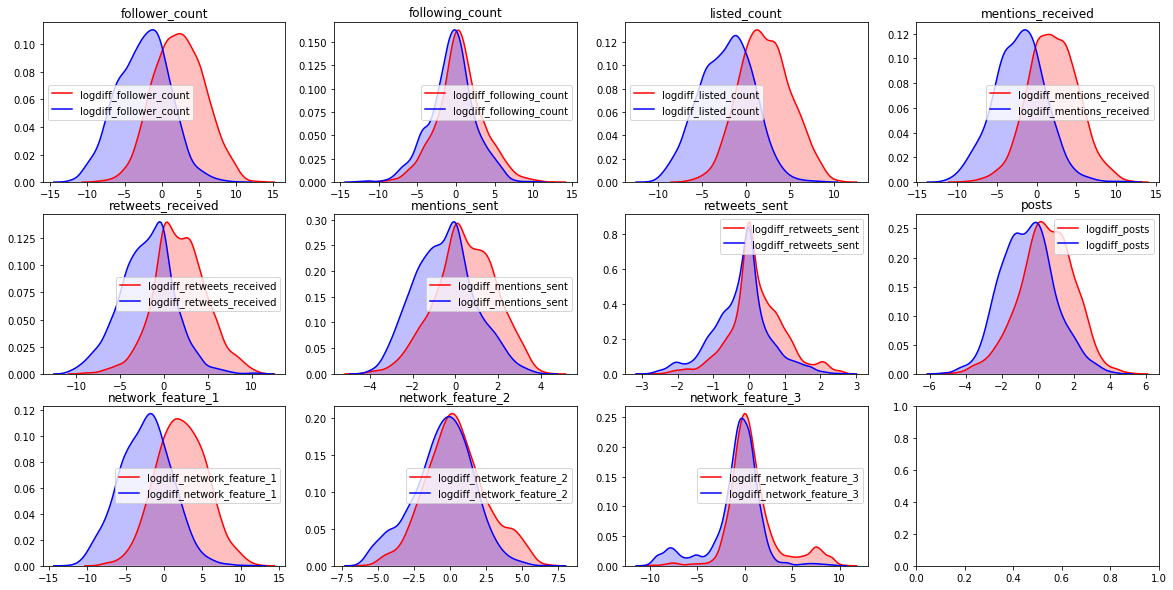

In [14]:
#check the density plot again, looks normal and more separatable
fig, ((ax1,ax2,ax3,ax4),
      (ax5,ax6,ax7,ax8),
      (ax9,ax10,ax11,ax12)) = subplots(nrows = 3, ncols = 4, figsize = (20,10))

ax = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]

for i,f in enumerate(features):
    sns.kdeplot(train[train.Choice == 1]['logdiff_%s'%(f)],color = 'red', shade = 'True', ax = ax[i])
    sns.kdeplot(train[train.Choice == 0]['logdiff_%s'%(f)],color = 'blue', shade = 'True', ax = ax[i])
    ax[i].set_title(f)

#### Looks good now

## Binary Classification

### Train-test Split

In [15]:
#train test split
X = train.iloc[:,-11:]
y = train.Choice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
#class distribution
y.value_counts()/len(y)

1    0.509455
0    0.490545
Name: Choice, dtype: float64

### Gaussian Naive Bayes

In [17]:
clf_nb = GaussianNB()
clf_nb.fit(X_train,y_train)

y_pred_nb = clf_nb.predict(X_test)
y_pred_prob_nb = clf_nb.predict_proba(X_test)[:,1]

print 'ROC of NB:', roc_auc_score(y_test, y_pred_prob_nb)
print 'Accuracy of NB:',accuracy_score(y_test, y_pred_nb)

ROC of NB: 0.8595863289
Accuracy of NB: 0.763636363636


### Logistic Regression

In [18]:
#standardize
scaler = StandardScaler() 
X_train_lm = scaler.fit_transform(X_train)
X_test_lm = scaler.transform(X_test)

clf_lr = LogisticRegression()
C = [0.001, 0.01, 0.1, 1, 10]
penalty = ['l2','l1']
param_grid = dict(C = C, penalty = penalty)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_lr = GridSearchCV(clf_lr, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_search_lr.fit(X_train_lm, y_train)
print('best cv params:', grid_search_lr.best_params_)

#fit
y_pred_lr = grid_search_lr.predict(X_test_lm)
y_pred_prob_lr = grid_search_lr.predict_proba(X_test_lm)[:,1]

('best cv params:', {'penalty': 'l1', 'C': 10})


In [19]:
print 'ROC of Logistic Regression:', roc_auc_score(y_test, y_pred_prob_lr)
print 'Accuracy of Logistic Regression:', accuracy_score(y_test, y_pred_lr)

ROC of Logistic Regression: 0.870497466165
Accuracy of Logistic Regression: 0.776363636364


### SVC

In [20]:
clf_svc = LinearSVC()
C = [0.0001, 0.001, 0.01, 0.1, 1, 10]
loss = ['squared_hinge', 'hinge']
param_grid = dict(C = C, loss = loss)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_svc = GridSearchCV(clf_svc, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_search_svc.fit(X_train_lm, y_train)
print('best cv params:', grid_search_svc.best_params_)

y_pred_svc = grid_search_svc.predict(X_test_lm)
y_pred_prob_svc = grid_search_svc.decision_function(X_test_lm)

('best cv params:', {'loss': 'squared_hinge', 'C': 0.1})


In [21]:
print 'ROC of SVC:', roc_auc_score(y_test, y_pred_prob_svc)
print 'Accuracy of SVC:', accuracy_score(y_test, y_pred_svc)

ROC of SVC: 0.870560646734
Accuracy of SVC: 0.776363636364


### QDA

In [22]:
clf_qda = QDA()
clf_qda.fit(X_train, y_train)

y_pred_qda = clf_qda.predict(X_test)
y_pred_prob_qda = clf_qda.predict_proba(X_test)[:,1]

In [23]:
print 'ROC of QDA:', roc_auc_score(y_test, y_pred_prob_qda)
print 'Accuracy of QDA:', accuracy_score(y_test, y_pred_qda)

ROC of QDA: 0.865397471896
Accuracy of QDA: 0.775757575758


### Random Forest

In [24]:
clf_rf = RandomForestClassifier()
n_estimators = [300, 500, 800]
max_features = ['sqrt', 'log2', None]
param_grid = dict(max_features=max_features, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_rf = GridSearchCV(clf_rf, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_search_rf.fit(X_train, y_train)
print('best cv params:', grid_search_rf.best_params_)

('best cv params:', {'max_features': 'log2', 'n_estimators': 500})


In [25]:
y_pred_rf = grid_search_rf.predict(X_test)
y_pred_prob_rf = grid_search_rf.predict_proba(X_test)[:,1]

In [26]:
print 'ROC of Random Forest:', roc_auc_score(y_test, y_pred_prob_rf)
print 'Accuracy of Random Forest:', accuracy_score(y_test, y_pred_rf)

ROC of Random Forest: 0.859626735078
Accuracy of Random Forest: 0.771515151515


### XGBoost

In [27]:
clf_xgb = XGBClassifier()
n_estimators = [200,500]
learning_rate = [0.001, 0.01, 0.1]
reg_lambda = [0.001, 0.01, 0.1, 1, 10]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators,reg_lambda = reg_lambda)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_xgb = GridSearchCV(clf_xgb, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_search_xgb.fit(X_train, y_train)
print('best cv params:', grid_search_xgb.best_params_)

y_pred_xgb = grid_search_xgb.predict(X_test)
y_pred_prob_xgb = grid_search_xgb.predict_proba(X_test)[:,1]

('best cv params:', {'n_estimators': 500, 'learning_rate': 0.01, 'reg_lambda': 0.001})


In [28]:
print 'ROC of XGBoost:', roc_auc_score(y_test, y_pred_prob_xgb)
print 'Accuracy of XGBoost:', accuracy_score(y_test, y_pred_xgb)

ROC of XGBoost: 0.870257233073
Accuracy of XGBoost: 0.775151515152


### Feature Importance

#### XGBoost

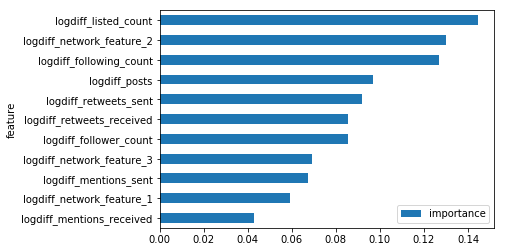

In [29]:
##feature importance
clf_xgb = XGBClassifier(n_estimators=100, subsample=1, learning_rate=0.1, reg_lambda=1)
clf_xgb.fit(X_train, y_train)
fimp_xgb = zip(X.columns.values.tolist(),clf_xgb.feature_importances_.tolist())
fimp_xgb = pd.DataFrame(sorted(fimp_xgb, key = lambda x: x[1], reverse=True), columns=['feature','importance']).set_index('feature')
fimp_xgb.sort_values(by = 'importance',ascending=True).plot(kind = 'barh')

#### Logistic Regression

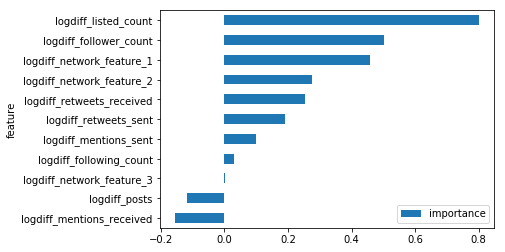

In [30]:
clf_lr = LogisticRegression(penalty='l2', C=0.1)
clf_lr.fit(X_train_lm, y_train)
fimp_lr = zip(X.columns.values.tolist(),clf_lr.coef_[0].tolist())
fimp_lr = pd.DataFrame(sorted(fimp_lr, key = lambda x: x[1], reverse=True), columns=['feature','importance']).set_index('feature')
fimp_lr.sort_values(by = 'importance',ascending=True).plot(kind = 'barh')

Combining results from two models, we'll use `listed_count`, `follower_count`, `statuses_count` and 3 network statistics as the indicators for influencer.

### Confusion Matrix

In [31]:
cm = confusion_matrix(y_test, y_pred_lr)
print cm

[[626 193]
 [176 655]]


## Application

When promoting a Public Relations plan, PR professionals usually reach out to the more influential twitter accounts to dissenminate promotinal content.

Being able to reachout the influencers, not only reduces the cost but also allows the targeting message to be more customized, thus increasing the chance of conversion.

By using our model, we will be able to identify the most important variables in determining whether a user is an influencer. Then, we will be able to focus the budget spend only on the influential twitter accounts. 

Since when a influencer tweets, their followers also have a higher chance of converting to a customer. Please refer to the next section for an example that showcases positive financial impact when using our test dataset.

## Financial Impact

In [32]:
#relevant cost and prob
margin = 10
p1 = 0.0005
p2 = 0.00075
cost = 10

In [33]:
#we used predictions from Logistic Regression to calculate financial impact
financial = train.iloc[X_test.index.tolist(),:][['A_follower_count','B_follower_count','Choice']]
financial['Prediction'] = y_pred_lr
financial['Correct'] = (financial.Choice == financial.Prediction)
financial.head()

,A_follower_count,B_follower_count,Choice,Prediction,Correct
770,44034,1205166,0,1,False
1844,14003896,1279,1,1,True
3538,627949,750,0,1,False
608,58963,3601,0,1,False
3554,1641075,1834007,0,0,True


### Without Model

In [34]:
np_nomod = (financial.A_follower_count*financial.Choice + financial.B_follower_count*(1-financial.Choice))*p1*margin - cost
np_nomod_sum = np_nomod.sum()
print('Total net profit without the model prediction: $%s'%(np_nomod_sum))

Total net profit without the model prediction: $8474334.655


### With Model

In [35]:
np_mod = financial.Correct*((financial.A_follower_count*financial.Prediction + financial.B_follower_count*(1-financial.Prediction)))*p2*margin - cost
np_mod_sum = np_mod.sum()
print('Total net profit with the model prediction: $%s'%(np_mod_sum))

Total net profit with the model prediction: $12033633.3225


### Perfect Model

In [36]:
np_pmod = ((financial.A_follower_count*financial.Prediction + financial.B_follower_count*(1-financial.Prediction)))*p2*margin - cost
np_pmod_sum = np_pmod.sum()
print('Total net profit with the perfect model prediction: $%s'%(np_pmod_sum))

Total net profit with the perfect model prediction: $14292657.5475


### Lift 

In [37]:
lift_mod = round(np_mod_sum*1.0/np_nomod_sum,4)
lift_pmod = round(np_pmod_sum*1.0/np_nomod_sum,4)

print 'Lift from using our classification model = {}'.format(lift_mod)
print 'Lift from using a perfect classification model = {}'.format(lift_pmod)


Lift from using our classification model = 1.42
Lift from using a perfect classification model = 1.6866


# PART II

### tweets streaming in separate py file (please see attached files)

### search word: *grammy*

In [38]:
import json
f = open('data/stream_grammy.json')
lines = f.readlines()
tweets = []
for l in lines:
    tweets.append(json.loads(l))
tweets = tweets[:5000]

In [39]:
n = len(tweets)

In [40]:
user1 = []
user2 = []
tweet_type = []
tweet_text = []

In [41]:
for i in range(n):
    user_rt = ''
    user_reply = ''
    user_tw = tweets[i]['user']['screen_name']
    txt = tweets[i]['text']
    if tweets[i]['entities']['user_mentions']: #if any @ in tweets
        user_mentioned = [m['screen_name'] for m in tweets[i]['entities']['user_mentions']] #store all @ screen names 
        if 'retweeted_status' in tweets[i].keys(): #if RT
            user_rt = tweets[i]['retweeted_status']['user']['screen_name'] 
            user1.append(user_tw) #add one more link for RT
            user2.append(user_rt)
            tweet_type.append('RT')
            tweet_text.append(txt)
            user1.append(user_rt) #add one more link for og tweet, drop dup later
            user2.append(user_rt)
            tweet_type.append('tweet')
            tweet_text.append(tweets[i]['retweeted_status']['text'])
        elif tweets[i]['in_reply_to_screen_name']:
            user_reply = tweets[i]['in_reply_to_screen_name']
            user1.append(user_tw) #add one more link for reply
            user2.append(user_reply)
            tweet_type.append('reply')
            tweet_text.append(txt)
        for u in [user for user in user_mentioned if (user != user_rt and user != user_reply)]:
            user1.append(user_tw) #add one more link for mention (exclude RT, reply)
            user2.append(u)
            tweet_type.append('mention')
            tweet_text.append(txt)
    else: #if no @ in tweet
        user1.append(user_tw)
        user2.append(user_tw)
        tweet_type.append('tweet')
        tweet_text.append(txt)

In [42]:
tweet_df = pd.DataFrame(zip(user1,user2,tweet_type,tweet_text),columns = ['user1','user2','type','text'])

In [43]:
tweet_df = tweet_df.drop_duplicates()[['user1','user2','type']]

In [44]:
tweet_df.head()

,user1,user2,type
0,RubberD01,LawyerRogelio,RT
1,LawyerRogelio,LawyerRogelio,tweet
2,Herzlinie,majortomzin,RT
3,majortomzin,majortomzin,tweet
4,PhilReality,PhilReality,tweet


In [45]:
tweet_df.to_csv('output/grammy.csv')

### calculate centrality, betweenness, closeness

In [46]:
tweet_link = tweet_df.groupby(['user1','user2']).count().reset_index()

In [47]:
user_from = tweet_link.user1.tolist()
user_to = tweet_link.user2.tolist()
weight = tweet_link.type.tolist()

In [48]:
import networkx as nx
G = nx.DiGraph()

In [49]:
for i in range(len(user_from)):
    G.add_edge(user_from[i],user_to[i], weight = weight[i])

In [50]:
users = G.nodes

In [51]:
degree = nx.degree_centrality(G)
between = nx.betweenness_centrality(G)
close = nx.closeness_centrality(G)

In [52]:
user_stats_central = pd.DataFrame(zip(users,degree.values(),between.values(),close.values()),columns = ['user_name','degree','between','close'])

In [53]:
user_stats_central.head()

,user_name,degree,between,close
0,skeletonsugar,0.000180,0.000000e+00,0.00000
1,StacyBrewer18,0.000180,0.000000e+00,0.00000
2,butteredclam,0.000359,0.000000e+00,0.00000
3,DoroSahn,0.000180,0.000000e+00,0.00000
4,switchspears,0.000718,3.223796e-08,0.00018


### User Stats (listed_count, follower_count, statuses_count)

In [54]:
user_stats = {}
for i in range(n):
    user_tw = tweets[i]['user']['screen_name']
    if 'retweeted_status' in tweets[i].keys():
        user_rt = tweets[i]['retweeted_status']['user']['screen_name']
    if user_tw not in user_stats:
        user_stats[user_tw] = {}
        user_stats[user_tw]['listed_count'] = tweets[i]['user']['listed_count']
        user_stats[user_tw]['followers_count'] = tweets[i]['user']['followers_count']
        user_stats[user_tw]['statuses_count'] = tweets[i]['user']['statuses_count']
    if user_rt not in user_stats:
        user_stats[user_rt] = {}
        user_stats[user_rt]['listed_count'] = tweets[i]['retweeted_status']['user']['listed_count']
        user_stats[user_rt]['followers_count'] = tweets[i]['retweeted_status']['user']['followers_count']
        user_stats[user_rt]['statuses_count'] = tweets[i]['retweeted_status']['user']['statuses_count']

In [55]:
user_stats_api = pd.DataFrame.from_dict({i: user_stats[i] for i in user_stats.keys()},orient='index').drop_duplicates()
user_stats_api = user_stats_api.reset_index()
user_stats_api.columns = ['user_name','listed_count','followers_count','statuses_count']

In [56]:
user_stats_api.head()

,user_name,listed_count,followers_count,statuses_count
0,00lightwoodia,340,16766,4
1,01jodis,113,4024,2
2,087JAYBUM,467,4395,3
3,0nefinity,2055,357118,160
4,1000alana,278,39757,0


### Merge two dataframes (api stats and centrality)

In [57]:
user_stats_overall = user_stats_api.merge(user_stats_central,left_on='user_name',right_on='user_name')

In [58]:
w = [0.3,0.25,0.15,0.3]

In [59]:
user_factor = user_stats_overall
user_factor['central'] = user_factor.degree + user_factor.between + user_factor.close
user_factor = user_factor.drop(['degree','between','close'],axis = 1)

In [60]:
scaler = StandardScaler() #standardize
user_factor_norm = pd.DataFrame(scaler.fit_transform(user_factor[['listed_count','followers_count','statuses_count','central']]))
user_factor_norm['user_name'] = user_factor['user_name']
user_factor_norm['score'] = user_factor_norm.iloc[:,0]*w[0] + user_factor_norm.iloc[:,1]*w[1] + user_factor_norm.iloc[:,2]*w[2] + user_factor_norm.iloc[:,3]*w[3]
user_factor_norm.columns = ['listed_count','followers_count','statuses_count','central','user_name','score']
result = user_factor_norm[['user_name','score','listed_count','followers_count','statuses_count','central']].sort_values(by = 'score', ascending = False)[:50]

In [61]:
result

,user_name,score,listed_count,followers_count,statuses_count,central
3860,ladygaga,25.456250,56.007645,-0.188352,58.230480,-0.111757
4748,shakira,14.950998,37.085088,-0.212359,26.080592,-0.111757
4351,notiven,14.847655,-0.022378,59.388918,0.271110,-0.111757
2708,bombgoddess_,12.107594,-0.060331,0.031658,-0.069747,40.427468
1602,PotatochiplfeV2,8.287463,-0.060857,-0.210386,-0.070263,27.896188
557,Diddy,7.720085,10.424958,0.034645,8.826571,10.866501
3727,julizivic,7.516610,-0.060417,-0.209549,-0.070521,25.325670
4559,rachlack,6.100132,-0.060402,-0.220957,-0.069489,20.613052
1633,RATEDRIANA,6.067594,-0.060614,-0.221865,-0.070263,20.505947
183,Asimon301,5.453360,-0.060773,-0.236308,-0.070778,18.470952


#### we also did search word: *superbowl* <font color='green'>(for extra credits)</font>

In [62]:
import json
f = open('data/stream_superbowl.json')
lines = f.readlines()
tweets = []
for l in lines:
    tweets.append(json.loads(l))
tweets = tweets[:5000]

In [63]:
n = len(tweets)

In [65]:
user1 = []
user2 = []
tweet_type = []
tweet_text = []

In [66]:
for i in range(n):
    user_rt = ''
    user_reply = ''
    user_tw = tweets[i]['user']['screen_name']
    txt = tweets[i]['text']
    if tweets[i]['entities']['user_mentions']: #if any @ in tweets
        user_mentioned = [m['screen_name'] for m in tweets[i]['entities']['user_mentions']] #store all @ screen names 
        if 'retweeted_status' in tweets[i].keys(): #if RT
            user_rt = tweets[i]['retweeted_status']['user']['screen_name'] 
            user1.append(user_tw) #add one more link for RT
            user2.append(user_rt)
            tweet_type.append('RT')
            tweet_text.append(txt)
            user1.append(user_rt) #add one more link for og tweet, drop dup later
            user2.append(user_rt)
            tweet_type.append('tweet')
            tweet_text.append(tweets[i]['retweeted_status']['text'])
        elif tweets[i]['in_reply_to_screen_name']:
            user_reply = tweets[i]['in_reply_to_screen_name']
            user1.append(user_tw) #add one more link for reply
            user2.append(user_reply)
            tweet_type.append('reply')
            tweet_text.append(txt)
        for u in [user for user in user_mentioned if (user != user_rt and user != user_reply)]:
            user1.append(user_tw) #add one more link for mention (exclude RT, reply)
            user2.append(u)
            tweet_type.append('mention')
            tweet_text.append(txt)
    else: #if no @ in tweet
        user1.append(user_tw)
        user2.append(user_tw)
        tweet_type.append('tweet')
        tweet_text.append(txt)

In [67]:
tweet_df = pd.DataFrame(zip(user1,user2,tweet_type,tweet_text),columns = ['user1','user2','type','text'])

In [68]:
tweet_df = tweet_df.drop_duplicates()[['user1','user2','type']]

In [69]:
tweet_df.to_csv('output/superbowl.csv')

### calculate centrality, betweenness, closeness

In [70]:
tweet_link = tweet_df.groupby(['user1','user2']).count().reset_index()

In [71]:
user_from = tweet_link.user1.tolist()
user_to = tweet_link.user2.tolist()
weight = tweet_link.type.tolist()

In [72]:
import networkx as nx
G = nx.DiGraph()

In [73]:
for i in range(len(user_from)):
    G.add_edge(user_from[i],user_to[i], weight = weight[i])

In [74]:
users = G.nodes

In [75]:
degree = nx.degree_centrality(G)
between = nx.betweenness_centrality(G)
close = nx.closeness_centrality(G)

In [76]:
user_stats_central = pd.DataFrame(zip(users,degree.values(),between.values(),close.values()),columns = ['user_name','degree','between','close'])

### User Stats (listed_count, follower_count, statuses_count)

In [77]:
user_stats = {}
for i in range(n):
    user_tw = tweets[i]['user']['screen_name']
    if 'retweeted_status' in tweets[i].keys():
        user_rt = tweets[i]['retweeted_status']['user']['screen_name']
    if user_tw not in user_stats:
        user_stats[user_tw] = {}
        user_stats[user_tw]['listed_count'] = tweets[i]['user']['listed_count']
        user_stats[user_tw]['followers_count'] = tweets[i]['user']['followers_count']
        user_stats[user_tw]['statuses_count'] = tweets[i]['user']['statuses_count']
    if user_rt not in user_stats:
        user_stats[user_rt] = {}
        user_stats[user_rt]['listed_count'] = tweets[i]['retweeted_status']['user']['listed_count']
        user_stats[user_rt]['followers_count'] = tweets[i]['retweeted_status']['user']['followers_count']
        user_stats[user_rt]['statuses_count'] = tweets[i]['retweeted_status']['user']['statuses_count']

In [78]:
user_stats_api = pd.DataFrame.from_dict({i: user_stats[i] for i in user_stats.keys()},orient='index').drop_duplicates()
user_stats_api = user_stats_api.reset_index()
user_stats_api.columns = ['user_name','listed_count','followers_count','statuses_count']

### Merge two dataframes (api stats and centrality)

In [79]:
user_stats_overall = user_stats_api.merge(user_stats_central,left_on='user_name',right_on='user_name')

In [80]:
w = [0.3,0.25,0.15,0.3]

In [81]:
user_factor = user_stats_overall
user_factor['central'] = user_factor.degree + user_factor.between + user_factor.close
user_factor = user_factor.drop(['degree','between','close'],axis = 1)

In [82]:
scaler = StandardScaler() #standardize
user_factor_norm = pd.DataFrame(scaler.fit_transform(user_factor[['listed_count','followers_count','statuses_count','central']]))
user_factor_norm['user_name'] = user_factor['user_name']
user_factor_norm['score'] = user_factor_norm.iloc[:,0]*w[0] + user_factor_norm.iloc[:,1]*w[1] + user_factor_norm.iloc[:,2]*w[2] + user_factor_norm.iloc[:,3]*w[3]
user_factor_norm.columns = ['listed_count','followers_count','statuses_count','central','user_name','score']
result = user_factor_norm[['user_name','score','listed_count','followers_count','statuses_count','central']].sort_values(by = 'score', ascending = False)[:50]

In [83]:
result

,user_name,score,listed_count,followers_count,statuses_count,central
2447,SassyCassyCat,16.093450,-0.071697,2.225600,-0.094966,51.909346
1514,KingJames,15.921627,43.134190,-0.230013,20.416411,-0.078630
931,Favstar_Bot,14.970621,-0.018123,59.860199,0.230650,-0.078630
1936,NFL,11.420318,26.010628,0.941126,22.702912,-0.078630
969,FoxNews,10.515625,18.181191,2.406607,29.888033,-0.078630
1152,HillaryClinton,9.615100,22.865499,-0.197698,18.986388,-0.143611
5119,tinkerella66,9.118500,-0.079693,-0.222689,-0.127096,30.723814
453,CNNEE,9.019842,17.488921,0.741207,24.076348,-0.078630
1460,Kauaibride,7.470652,-0.043790,0.759933,0.170226,24.227572
1723,ManUtd,6.807010,18.190796,0.054186,9.195385,-0.143611
